In [1]:
# Imports for API to get data

import csv
import requests
import pandas as pd
import numpy as np
import re
from lxml import html
import json

In [2]:
# Data Processing Imports

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
# ML Imports

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout, Lambda, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from tensorflow.keras.utils import Sequence
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [42]:
# Countries to Model on
cols = ['date', 'China', 'Italy', 'South Korea', 'France', 'Spain', 'Germany', 'United States', 'United Kingdom', 'India']

# Fetch Data
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
response = requests.get(url).content.decode('utf-8')
cr = csv.reader(response.splitlines(), delimiter=',')

In [43]:
# Preprocessing Data to start the time series from the day 
# when cases hit 50 for each country. Further documentation available
# on request.
# Author: Archit Checker <archit.checker@alumni.ashoka.edu.in>

df = pd.DataFrame(cr, index=None,)
headers = df.iloc[0]
df  = pd.DataFrame(df.values[1:], columns=headers)
df = df[cols]
max_day = 0
def parse(val):
    val = re.sub('\D', '', val)
    return int(val)

current_X = []
for col in cols[1:]:
    day = 1
    arr = df[col]
    for element in list(arr):
        try:
            if int(element) >= 50:
                if col =="China" and int(element) == 59 and day == 2:
                    continue
                current_X.append([col, day, int(element)])
                day += 1
        except:
            if day!=1:
                day += 1
#   Special treatment for india - fetch latest datapoint from mohw.
    if col == "India":
        page = requests.get("https://www.mohfw.gov.in/")
        tree = html.fromstring(page.content)
        cases = []
        cases.append(tree.xpath('//*[@id="site-dashboard"]/div/div/div/div/ul/li[1]/strong/text()')[0])
        cases.append(tree.xpath('//*[@id="site-dashboard"]/div/div/div/div/ul/li[2]/strong/text()')[0])
        cases.append(tree.xpath('//*[@id="site-dashboard"]/div/div/div/div/ul/li[3]/strong/text()')[0])
        cases.append(tree.xpath('//*[@id="site-dashboard"]/div/div/div/div/ul/li[4]/strong/text()')[0])
        x = 0
        print(cases)
        for case in cases:
            x += parse(case)
        current_X[len(current_X)-1] = [col, day-1, x]
    if day > max_day:
        max_day = day
new_df = pd.DataFrame(current_X, columns=["country", "days", "cases"])
print(max_day)

['197387', '295880', '15685', '1']
165


In [44]:
# Grouping Data by Country

grouped = new_df.pivot(index = "days", columns = "country")
grouped = grouped.swaplevel(i = 0, j = 1, axis = 1)
df = grouped.reindex(sorted(grouped.columns), axis=1)

In [45]:
df

country,China,France,Germany,India,Italy,South Korea,Spain,United Kingdom,United States
,cases,cases,cases,cases,cases,cases,cases,cases,cases
days,,,,,,,,,
1,59.0,57.0,57.0,50.0,79.0,80.0,54.0,51.0,53.0
2,63.0,100.0,111.0,73.0,132.0,155.0,82.0,85.0,53.0
3,80.0,130.0,129.0,75.0,229.0,345.0,136.0,115.0,59.0
4,216.0,178.0,157.0,83.0,322.0,601.0,192.0,163.0,60.0
5,235.0,212.0,196.0,90.0,400.0,762.0,267.0,206.0,66.0
...,...,...,...,...,...,...,...,...,...
160,84624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,84653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
toReduce = df['India'].count()

In [50]:
# Shifting time series to account for lengthy China History

i = 0
for country, param in df:
    try:
        norm_shift = np.where(df[country][param].isna())[0][0]
        df[country][param] = df[country][param].shift((max_day - norm_shift - 1))
    except:
        pass

for country, param in df:
        df[country][param] = df[country][param].fillna(0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [53]:
# Cut all added zeros by using country with least values
df = df.iloc[len(df)-int(toReduce):]

In [54]:
df

country,China,France,Germany,India,Italy,South Korea,Spain,United Kingdom,United States
,cases,cases,cases,cases,cases,cases,cases,cases,cases
days,,,,,,,,,
56,80908.0,1784.0,1296.0,50.0,10149.0,7755.0,2299.0,373.0,1025.0
57,80932.0,2281.0,1567.0,73.0,12462.0,7869.0,3274.0,456.0,1312.0
58,80954.0,2876.0,2369.0,75.0,15113.0,7979.0,4427.0,590.0,1663.0
59,80973.0,3661.0,3062.0,83.0,17660.0,8086.0,5958.0,707.0,2174.0
60,80995.0,4499.0,3795.0,90.0,21157.0,8162.0,7641.0,1140.0,2951.0
...,...,...,...,...,...,...,...,...,...
160,84624.0,160750.0,190862.0,440215.0,238720.0,12484.0,246504.0,305289.0,2312302.0
161,84653.0,161267.0,191449.0,456183.0,238833.0,12535.0,246752.0,306210.0,2347022.0


In [55]:
cols = list(df)
cols

[('China', 'cases'),
 ('France', 'cases'),
 ('Germany', 'cases'),
 ('India', 'cases'),
 ('Italy', 'cases'),
 ('South Korea', 'cases'),
 ('Spain', 'cases'),
 ('United Kingdom', 'cases'),
 ('United States', 'cases')]

In [56]:
# Basic rearrangement, moving india to last column

col = df.pop(('India', 'cases'))
df.insert(len(cols)-1, col.name, col)

In [57]:
df

country,China,France,Germany,Italy,South Korea,Spain,United Kingdom,United States,India
,cases,cases,cases,cases,cases,cases,cases,cases,cases
days,,,,,,,,,
56,80908.0,1784.0,1296.0,10149.0,7755.0,2299.0,373.0,1025.0,50.0
57,80932.0,2281.0,1567.0,12462.0,7869.0,3274.0,456.0,1312.0,73.0
58,80954.0,2876.0,2369.0,15113.0,7979.0,4427.0,590.0,1663.0,75.0
59,80973.0,3661.0,3062.0,17660.0,8086.0,5958.0,707.0,2174.0,83.0
60,80995.0,4499.0,3795.0,21157.0,8162.0,7641.0,1140.0,2951.0,90.0
...,...,...,...,...,...,...,...,...,...
160,84624.0,160750.0,190862.0,238720.0,12484.0,246504.0,305289.0,2312302.0,440215.0
161,84653.0,161267.0,191449.0,238833.0,12535.0,246752.0,306210.0,2347022.0,456183.0


Washington
Illinois
California
Arizona
Massachusetts
Wisconsin
Texas
Nebraska
Utah
Oregon
Florida
New York
Rhode Island
Georgia
New Hampshire
North Carolina
New Jersey
Colorado
Maryland
Nevada
Tennessee
Hawaii
Indiana
Kentucky
Minnesota
Oklahoma
Pennsylvania
South Carolina
District of Columbia
Kansas
Missouri
Vermont
Virginia
Connecticut
Iowa
Louisiana
Ohio
Michigan
South Dakota
Arkansas
Delaware
Mississippi
New Mexico
North Dakota
Wyoming
Alaska
Maine
Alabama
Idaho
Montana
Puerto Rico
Virgin Islands
Guam
West Virginia
Washington
Illinois
California
Arizona
Massachusetts
Wisconsin
Texas
Nebraska
Utah
Oregon
Florida
New York
Rhode Island
Georgia
New Hampshire
North Carolina
New Jersey
Colorado
Maryland
Nevada
Tennessee
Hawaii
Indiana
Kentucky
Minnesota
Oklahoma
Pennsylvania
South Carolina
District of Columbia
Kansas
Missouri
Vermont
Virginia
Connecticut
Iowa
Louisiana
Ohio
Michigan
South Dakota
Arkansas
Delaware
Mississippi
New Mexico
North Dakota
Wyoming
Alaska
Maine
Alabama
Idaho
Mont

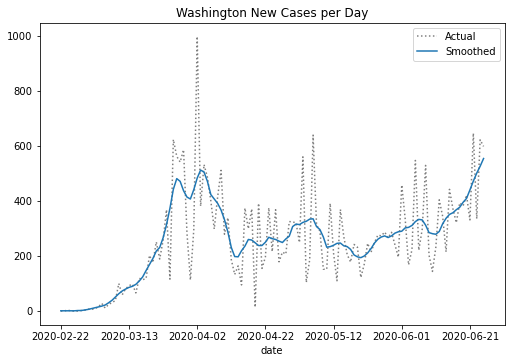

In [58]:
# Creation of US States Dataset, ignore India related values
dfz = pd.read_csv("/kaggle/input/nytimes-covid19-data/us-states.csv")
dfz = dfz.fillna(0)
def get_covid_india_data_api(url):
    response = requests.request("GET", url)
    return response.text.encode('utf8')

def flatten_and_parse_states_data(covid_data):
    flattened_data = []
    for day_data in covid_data:
        for region in day_data['regional']:
            flattened_data.append({
                'date' : day_data['day'],
                'state' : region['loc'],
                'case' : region['totalConfirmed']
            })
    
    states=pd.DataFrame(flattened_data)
    states.date = pd.to_datetime(states.date)
    return states

def fetch_covid_india_data(url):
    try:
        covid_data_json = get_covid_india_data_api(url)
        covid_data = json.loads(covid_data_json)['data']
        return flatten_and_parse_states_data(covid_data)
    except:
        print("API call failed")
        
#-------------------------------------------------------------------------
        
#url = "https://api.rootnet.in/covid19-in/stats/history"

states_df = dfz

#-------------------------------------------------------------------------------------------------------
states_df = states_df[states_df.state.str.contains('#')== False]
only_state_names = pd.unique(states_df[['state']].values.ravel('K'))
only_state_names
states_df[states_df.state !='Jharkhand#']
states = states_df.set_index(['state','date']).squeeze()


#--------------------------------------------------------------------------------------------
state_name = 'Washington'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name)

original, smoothed = prepare_cases(cases['cases'])

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

#----------------------------------------------------------------------------------------------------
TODAYS_LENGTH = len(states.xs('Washington'))
all_cases_list = []
for l in range(0,len(pd.unique(states_df[['state']].values.ravel('K')))-1):
    cases = states.xs(only_state_names[l])
    
    print(only_state_names[l])
    all_cases_list.append(cases['cases'])

allCasesList = []
for l in range(0,len(pd.unique(states_df[['state']].values.ravel('K')))-1):
    cases = states.xs(only_state_names[l])
    cases = cases['cases']
    print(only_state_names[l])
    cases.rename(only_state_names[l])
    
    if len(all_cases_list[0]) > len(cases):
        listofzeroes = [0]*(len(all_cases_list[0])-len(cases))
        cases = pd.concat([pd.Series(listofzeroes), cases])
    cases = cases.rename(only_state_names[l])
    allCasesList.append(cases)
#############################################################################################






In [59]:
# Dropping the superfluos column.
# Comment this out for more variables per country.

df = df.droplevel(1, axis = 1)

In [60]:
df.shape

(109, 9)

In [65]:
# Trimming DF to match List
print('State List Length:  ',len(allCasesList[0]))
print('National List Length: ', len(df['China']))
new_df = df

for l in allCasesList:
    new_df[l.name] = l.to_list()[len(l)-len(df['China']):]


State List Length:   157
National List Length:  109


In [72]:
new_df = new_df.iloc[max((df == 0).astype(int).sum(axis=0)):]
new_df

country,China,France,Germany,Italy,South Korea,Spain,United Kingdom,United States,India,Washington,...,Wyoming,Alaska,Maine,Alabama,Idaho,Montana,Puerto Rico,Virgin Islands,Guam,West Virginia
days,,,,,,,,,,,,,,,,,,,,,
64,81130.0,9134.0,8198.0,35713.0,8565.0,17688.0,2630.0,9415.0,165.0,908,...,15,6,32,39,9,8,5,2,3,1
65,81229.0,10995.0,14138.0,41035.0,8652.0,21735.0,3277.0,14250.0,191.0,1026,...,17,9,43,51,11,12,5,3,8,2
66,81281.0,12612.0,18187.0,47021.0,8799.0,26304.0,3983.0,19624.0,231.0,1228,...,18,12,52,78,23,19,6,3,12,5
67,81346.0,14459.0,21463.0,53578.0,8897.0,31750.0,5018.0,26747.0,320.0,1404,...,22,14,57,106,31,19,14,6,14,8
68,81484.0,16018.0,24774.0,59138.0,8961.0,36616.0,5683.0,35206.0,439.0,1655,...,24,21,70,131,42,29,21,6,15,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,84624.0,160750.0,190862.0,238720.0,12484.0,246504.0,305289.0,2312302.0,440215.0,29797,...,1197,859,2957,30021,4025,717,6525,76,1191,2543
161,84653.0,161267.0,191449.0,238833.0,12535.0,246752.0,306210.0,2347022.0,456183.0,30443,...,1230,869,2971,30454,4267,734,6564,76,1191,2571
162,84673.0,161348.0,192079.0,239410.0,12563.0,247086.0,306862.0,2381361.0,473105.0,30778,...,1254,905,2994,31097,4412,743,6685,76,1194,2593


## The Final DataFrame with Values of States & Countries

In [73]:
new_df.head()

country,China,France,Germany,Italy,South Korea,Spain,United Kingdom,United States,India,Washington,...,Wyoming,Alaska,Maine,Alabama,Idaho,Montana,Puerto Rico,Virgin Islands,Guam,West Virginia
days,,,,,,,,,,,,,,,,,,,,,
64,81130.0,9134.0,8198.0,35713.0,8565.0,17688.0,2630.0,9415.0,165.0,908,...,15,6,32,39,9,8,5,2,3,1
65,81229.0,10995.0,14138.0,41035.0,8652.0,21735.0,3277.0,14250.0,191.0,1026,...,17,9,43,51,11,12,5,3,8,2
66,81281.0,12612.0,18187.0,47021.0,8799.0,26304.0,3983.0,19624.0,231.0,1228,...,18,12,52,78,23,19,6,3,12,5
67,81346.0,14459.0,21463.0,53578.0,8897.0,31750.0,5018.0,26747.0,320.0,1404,...,22,14,57,106,31,19,14,6,14,8
68,81484.0,16018.0,24774.0,59138.0,8961.0,36616.0,5683.0,35206.0,439.0,1655,...,24,21,70,131,42,29,21,6,15,12


In [74]:
new_df.shape

(101, 63)

### Scaling Data

In [75]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(new_df), columns=new_df.columns)

In [76]:
new_df.shape

(101, 63)

In [77]:
# Preparation for scaling the data
CompleteCaseList = []
for l in new_df:
    CompleteCaseList.append(df_scaled[l])
    

In [78]:
# Normalized array ro be used for training and testing. 
print('China List: ', CompleteCaseList[0])
print('Shape of Complete Array: ', np.array(CompleteCaseList).shape)


China List:  0      0.000000
1      0.027538
2      0.042003
3      0.060083
4      0.098470
         ...   
96     0.971905
97     0.979972
98     0.985535
99     0.993324
100    1.000000
Name: China, Length: 101, dtype: float64
Shape of Complete Array:  (63, 101)


In [79]:
train = np.array(CompleteCaseList)#.reshape(63,153)
(train.shape[0],train.shape[1])

(63, 101)

## Model & Data Construction Functions

In [80]:
from sklearn.model_selection import train_test_split
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def develop(train, history):
    holderX =[]
    holderY = []
    for l in train:
        X,y = split_sequence(l, n_steps_in=history,n_steps_out=14)
        holderX.append(X)
        holderY.append(y)
    holderX = np.array(holderX)
    holderY = np.array(holderY)
    trainingX, testingX,trainingY, testingY = train_test_split(holderX.reshape(holderX.shape[0]*holderX.shape[1], 1, history)
                                                               ,holderY.reshape(holderX.shape[0]*holderX.shape[1],14),
                                                               test_size=0.1, random_state=42)
    return trainingX, testingX,trainingY, testingY
    

In [81]:
TX, tx, TY, ty = develop(train=train, history = 8)

In [82]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
def build_model( train_x, train_y,   n_input, n_outputs = 14):
    # prepare data
    
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    #train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    # instantiating the model in the strategy scope creates the model on the TPU
   
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    #model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

model = build_model(TX, TY, n_input=14)

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               167200    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 14, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 200)           320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 14, 100)           20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 14, 1)             101       
Total params: 508,201
Trainable params: 508,201
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.fit(TX,TY)

142/142 [==============================] - 4s 25ms/step - loss: 0.0308


In [85]:
y_hat = model.predict(tx)

In [86]:
from sklearn.metrics import r2_score as r2

accy = r2(y_hat.reshape(y_hat.shape[0],14),ty)
print(accy)

0.9669503366853821


## Find Best Input Length

In [ ]:
modelList = []
maxima = []
inList = []
for l in range(15,30):
    print('Model Number: '+ str(l))
    print('Input Length: '+str(l))
    TX, tx, TY, ty = develop(train=train, history = l)
    model = build_model(TX, TY, n_input=l)
    model.fit(TX, TY, epochs = 15, batch_size = 128)
    y_hat = model.predict(tx)
    accy = r2(y_hat.reshape(y_hat.shape[0],14),ty)
    print('R-2 Score: ', str(accy))
    maxima.append(accy)
    modelList.append(model.summary())
    inList.append(l)
    plt.plot(maxima)
    print('-----------------------------------------------------------------')
    print(' ')
    
lengthOfInput = inList[np.argmax(maxima)]

In [ ]:
print('Best Input length: ', lengthOfInput)
print('Accuracy Achieved: ', maxima[np.argmax(maxima)])


## Accuracy Achieved in 15 Epochs


In [ ]:
# Create Train & Test Final Dataset 
TX, tx, TY, ty = develop(train=train, history =lengthOfInput) 

## Code to Run on System

In [ ]:
# from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import keras
n_timesteps, n_features, n_outputs = tx.shape[1],tx.shape[2], ty.shape[1]

def build_model(hp):
    
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32), 
                   activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                ), input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32), 
                   activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32), activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                ))))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
            metrics=[keras.metrics.RootMeanSquaredError(), 'mse'])
    return model

tuner = RandomSearch(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=5,
    directory='my_dir',
    project_name='COVIDGlobalModel2')

tuner.search_space_summary()

In [ ]:
tuner.search(TX, TY,
             epochs=15,
             validation_data=(tx, ty))

In [ ]:
tuner.results_summary()

In [ ]:
models = tuner.get_best_models(num_models=1)

In [ ]:
models[0].summary()
bestModel = models[0]

In [ ]:
bestModel.save('GlobalbestModel.h5')

In [ ]:
y_hat = bestModel.predict(tx)
accy = r2(y_hat.reshape(y_hat.shape[0],14),ty)
print('R-2 Score: ', str(accy))

In [ ]:
y_hat.shape

In [ ]:
tx.shape[1],tx.shape[2], tx.shape[1]

# End of Model Creation

In [ ]:
# Values predicted by the model
final_values = []
for l in CompleteCaseList:
    yHat = bestModel.predict(np.array(l[-lengthOfInput:]).reshape(1,1,lengthOfInput))
    final_values.append(l[lengthOfInput:].tolist()+yHat[0].tolist())

In [ ]:
toScaleArray = np.array(final_values).reshape(new_df.shape[0],new_df.shape[1])

In [ ]:
ScaledFinalValues = scaler.inverse_transform(toScaleArray)